In [3]:
'''
Christian Acosta Narvaez
proyecto etapa 5
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Al establecer n_init explícitamente, evitarás la advertencia:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)

# Paso 1: Cargar y visualizar los datos
data = pd.read_csv('sp500_companies.csv')  # Ajusta el nombre del archivo si es necesario
print(data.head())


FileNotFoundError: [Errno 2] No such file or directory: 'sp500_companies.csv'

In [ ]:

# Paso 2: Verificar y limpiar los datos
# Asegurar que no haya valores nulos
print(data.isnull().sum())
data = data.dropna()

# Asegurar que la columna Date esté en formato datetime y ordenar por Symbol y Date
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by=['Symbol', 'Date'])


Date      0
Symbol    0
close_    0
dtype: int64


In [ ]:

# Paso 3: Cálculo de Retornos Porcentuales Diarios
# Agrupar por Symbol y calcular la variación porcentual diaria del precio de cierre
data['Return'] = data.groupby('Symbol')['close_'].pct_change()
data = data.dropna(subset=['Return'])  # Eliminar filas con valores nulos en la columna de retornos
print(data)


            Date Symbol      close_    Return
674   2024-01-05      A  130.106781 -0.003359
675   2024-01-08      A  132.916992  0.021599
676   2024-01-09      A  130.226349 -0.020243
677   2024-01-10      A  130.634933  0.003137
678   2024-01-11      A  129.229828 -0.010756
...          ...    ...         ...       ...
29885 2024-03-22    ZTS  168.419785  0.003446
29886 2024-03-25    ZTS  167.332886 -0.006454
29887 2024-03-26    ZTS  165.198959 -0.012753
29888 2024-03-27    ZTS  168.030884  0.017143
29889 2024-03-28    ZTS  168.728912  0.004154

[28420 rows x 4 columns]


In [ ]:

# Paso 4: Cálculo de Indicadores de Volatilidad
# Calcular la desviación estándar, rango y media absoluta de los retornos diarios por empresa
volatility_metrics = data.groupby('Symbol').agg(
    std_return=('Return', 'std'),
    range_return=('Return', lambda x: x.max() - x.min()),
    mean_abs_return=('Return', lambda x: np.mean(np.abs(x)))  # (Opcional)
).reset_index()

print(volatility_metrics.head())



  Symbol  std_return  range_return  mean_abs_return
0      A    0.014066      0.064777         0.011360
1    AAL    0.028850      0.197241         0.018472
2    AAP    0.021332      0.114643         0.017060
3   AAPL    0.012664      0.073428         0.009779
4   ABBV    0.008689      0.038986         0.007548


In [ ]:

# Paso 5: Escalamiento de los Datos
scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(volatility_metrics[['std_return', 'range_return', 'mean_abs_return']])
scaled_volatility_metrics = pd.DataFrame(scaled_metrics, columns=['std_return', 'range_return', 'mean_abs_return'])
scaled_volatility_metrics['Symbol'] = volatility_metrics['Symbol']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

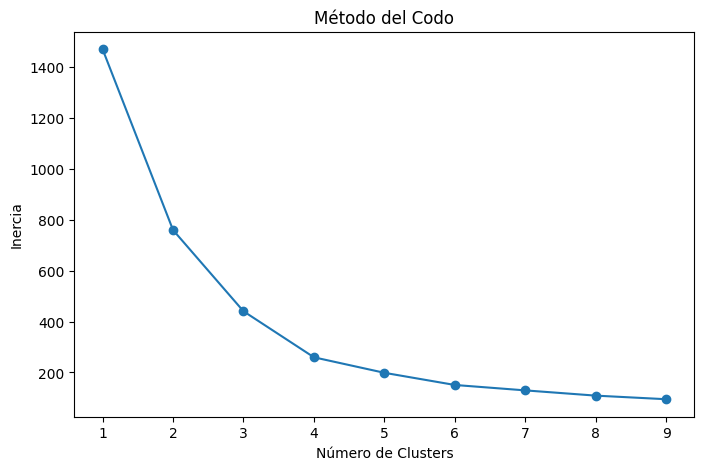

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

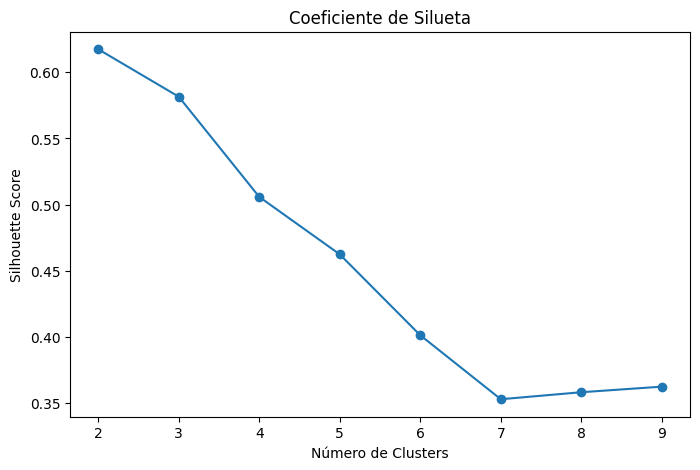

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:

# Paso 6: Clusterización
# Determinar el número óptimo de clusters usando el método del codo
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_metrics)
    inertia.append(kmeans.inertia_)

# Gráfico del método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

# Determinar el número óptimo de clusters usando el coeficiente de silueta
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_metrics)
    score = silhouette_score(scaled_metrics, kmeans.labels_)
    silhouette_scores.append(score)

# Gráfico del coeficiente de silueta
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Aplicar K-means con el número óptimo de clusters
optimal_k = 3  # Ajusta según el análisis anterior
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
scaled_volatility_metrics['Cluster'] = kmeans.fit_predict(scaled_metrics)


In [ ]:

# Paso 7: Reducción de Dimensionalidad para Visualización
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_metrics)
scaled_volatility_metrics['PCA1'] = pca_components[:, 0]
scaled_volatility_metrics['PCA2'] = pca_components[:, 1]


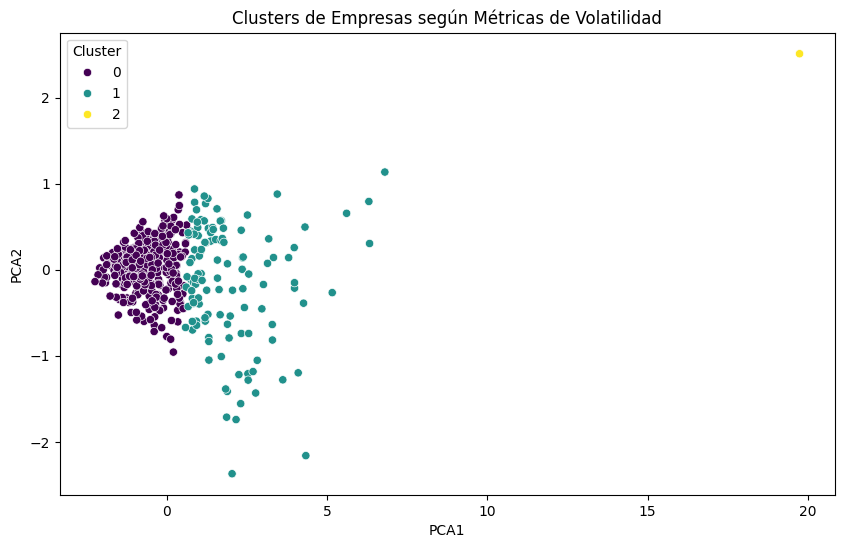

In [ ]:

# Paso 8: Visualización de los Resultados
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=scaled_volatility_metrics, palette='viridis')
plt.title('Clusters de Empresas según Métricas de Volatilidad')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


In [ ]:

# Paso 9: Análisis e Interpretación
# Aquí puedes hacer un análisis descriptivo de los clusters obtenidos
cluster_summary = scaled_volatility_metrics.groupby('Cluster').agg(
    avg_std_return=('std_return', 'mean'),
    avg_range_return=('range_return', 'mean'),
    avg_mean_abs_return=('mean_abs_return', 'mean'),
    count=('Symbol', 'count')
).reset_index()

print(cluster_summary)

   Cluster  avg_std_return  avg_range_return  avg_mean_abs_return  count
0        0       -0.412296         -0.426611            -0.370239    366
1        1        1.127055          1.195209             0.998113    123
2        2       12.272425          9.128842            12.739597      1


Patrones Observados

    **Cluster 0** (Mayoría de las Empresas):
    Interpretación: Este cluster agrupa la mayoría de las empresas (366), y se caracteriza por tener bajas métricas de volatilidad (valores negativos cercanos a cero). Estas empresas tienen movimientos de precios más estables y consistentes, lo cual sugiere que son empresas menos volátiles y con comportamientos relativamente predecibles.

    **Cluster 1** (Empresas Moderadamente Volátiles):
    Interpretación: Este cluster agrupa un conjunto de empresas que presentan una volatilidad moderada. Los retornos de estas empresas muestran variaciones más significativas comparadas con el Cluster 0. Estas empresas podrían tener un mayor riesgo, pero también podrían ofrecer mayores oportunidades de ganancia para los inversores que buscan tomar más riesgo.

    **Cluster 2 **(Empresa Extremadamente Volátil):
    Interpretación: Este cluster contiene solo una empresa con una volatilidad extremadamente alta. Las métricas de volatilidad son significativamente mayores en comparación con los otros clusters. Este tipo de empresa probablemente experimenta fluctuaciones extremas en su precio, lo que podría deberse a noticias importantes, resultados financieros muy volátiles o ser parte de un sector altamente especulativo.

Conclusiones Generales del Análisis y Clusterización

    Diversificación de Riesgo: El Cluster 0, que contiene la mayoría de las empresas, incluye compañías con retornos más estables, lo cual puede ser ideal para inversores que buscan minimizar el riesgo. El Cluster 1 agrupa empresas con un nivel de riesgo moderado, mientras que el Cluster 2 sugiere un nivel de riesgo extremo, probablemente atractivo para especuladores o inversores de alto riesgo.

    Segmentación del Portafolio: Este análisis permite a los inversores segmentar su portafolio en función del riesgo. Por ejemplo, podrían asignar un mayor porcentaje de su capital a empresas del Cluster 0 para asegurar estabilidad, mientras que podrían diversificar en empresas del Cluster 1 para capturar crecimiento con riesgo moderado. Las empresas en el Cluster 2 podrían ser consideradas para inversiones especulativas.

